# Conductance-Based Spiking Neural Network

Following derivatives are used for computing input estimate and voltage

$\frac{dV}{dt} = -V + \Gamma c - \Gamma^{2} (V - E) \cdot o$

$\frac{d\hat{x}}{dt} = -\hat{x} + \Gamma \cdot o$

Initialize parameters

In [1]:
import numpy as np
import pylab as pl
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.animation as animation
import random
import copy

Following functions are used for plotting the results

In [2]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

In [3]:
def multiplylist(vec, i):
    """ Multiplies every vector in a list with a scalar i. """
    
    new_vec = []
    
    for t in range(0, len(vec)):
        new_vec.append(vec[t] * i)
        
    return new_vec

In [77]:
def colors(N):
    """ Returns N times RGB-triple. """
    
    colors = []
    
    R = random.sample(range(0, 255), N)
    G = random.sample(range(0, 255), N)
    B = random.sample(range(0, 255), N)
    
    for i in range(N):
        colors.append(R[i])
        colors.append(G[i])
        colors.append(B[i])
    
    colors = D = np.asarray(colors).reshape((N, 3))
    
    return colors

## Single-neuron

Initialize parameters

In [207]:
def initialize_params_single(dt, iterations, gamma):
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike train
    o = np.zeros(iterations)

    # voltage
    voltage = np.zeros(iterations)

    # threshold
    T = (gamma**2) / 2

    # spike times
    spike = []
    t_spike = []
    
    return (t, x_est, o, voltage, T, spike, t_spike) 

Create time varying signal

In [208]:
def TVS_single():
    
    # create time-varying signal
    x = 5
    x_t = np.ones(iterations) * x

    step = 100
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 3

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

Run simulation

In [215]:
def run_single(E):
    for t in range(1, iterations):

        # udpate input estimate
        dxestdt = -x_est[t - 1] + gamma * o[t - 1]
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltage
        dVdt = -voltage[t - 1] + gamma * c[t - 1] - (gamma ** 2) * o[t - 1] * (voltage[t - 1] - E)
        voltage[t] = voltage[t - 1] + dt * dVdt

        # spike when voltage exceeds threshold
        if voltage[t] > T:
            o[t] = 1/dt #* np.abs(voltage[t] - E_e)

            # save spike times
            spike.append(1)
            t_spike.append(t)

Plot results (input + input estimate, voltage, spikes)

In [210]:
def plot_single():
    plots = 3
    pl.subplots(plots, 1, figsize=(8, 4))

    # enable LaTeX
    pl.rc('text', usetex=True)

    pl.subplot(plots, 1, 1)
    pl.plot(x, label=r'$x$', color='black')
    pl.title('Input and input estimate')
    pl.plot(x_est, label=r'$\hat{x}$', color='gray')
    pl.xlim(0, iterations)
#     pl.yticks([])
#     pl.xticks([])
    pl.legend()

    pl.subplot(plots, 1, 2)
    pl.title('Spikes')
    pl.plot(voltage, 'k')
    pl.xlim(0, iterations)
    pl.ylabel('Voltage')

    pl.subplot(plots, 1, 3)
    pl.title('Voltage')
    pl.scatter(t_spike, spike, c='k')
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xlabel('time')

### One neuron with reversal potential E

The following code computes the trajectory of the input estimate for one neuron with reversal potential E

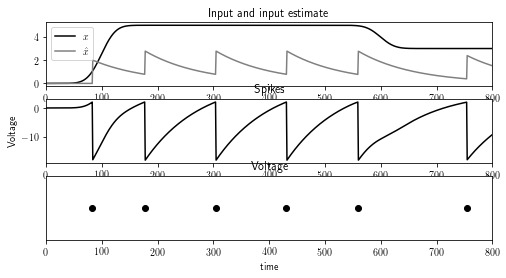

In [280]:
dt = 0.01
iterations = 800
gamma = 2
E = -3

t, x_est, o, voltage, T, spike, t_spike = initialize_params_single(dt, iterations, gamma)
x,c = TVS_single()
run_single(E)
plot_single()

Voltage dynamics:
    
$ \frac{dV}{dt} = -V + \Gamma c - \Gamma^{2} (V - E)$ 

Solve for $\frac{dV}{dt} = 0$

$ \frac{dV}{dt} = -V + \Gamma c - \Gamma^{2} V + \Gamma^{2} E = 0$

$V + \Gamma^{2} V  = \Gamma c + \Gamma^{2} E = 0$

$(1 + \Gamma^{2}) V = \Gamma c + \Gamma^{2} E$

$V = \frac{\Gamma c + \Gamma^{2}E}{1 + \Gamma^{2}}$

Text(0,0.5,'dVdt')

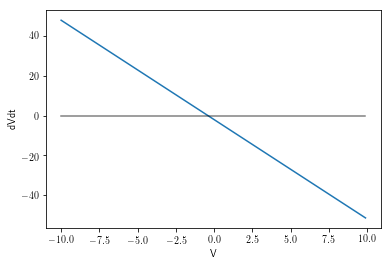

In [343]:
dVdt = []
c = 5

voltage = np.arange(-10, 10, 0.1)
for v in range(len(voltage)):
    temp = -voltage[v] + gamma * c - (gamma ** 2) * (voltage[v] - E)
    
    dVdt.append(temp)
    
pl.plot(voltage, dVdt)
pl.plot(voltage, voltage * 0, 'k', alpha=0.5)
pl.xlabel('V')
pl.ylabel('dVdt')

### One neuron with reversal potential E (multiple simulations)

The following code computes the trajectory of the input estimate for one neuron. Different reversal potentials (E) are chosen for the different runs.

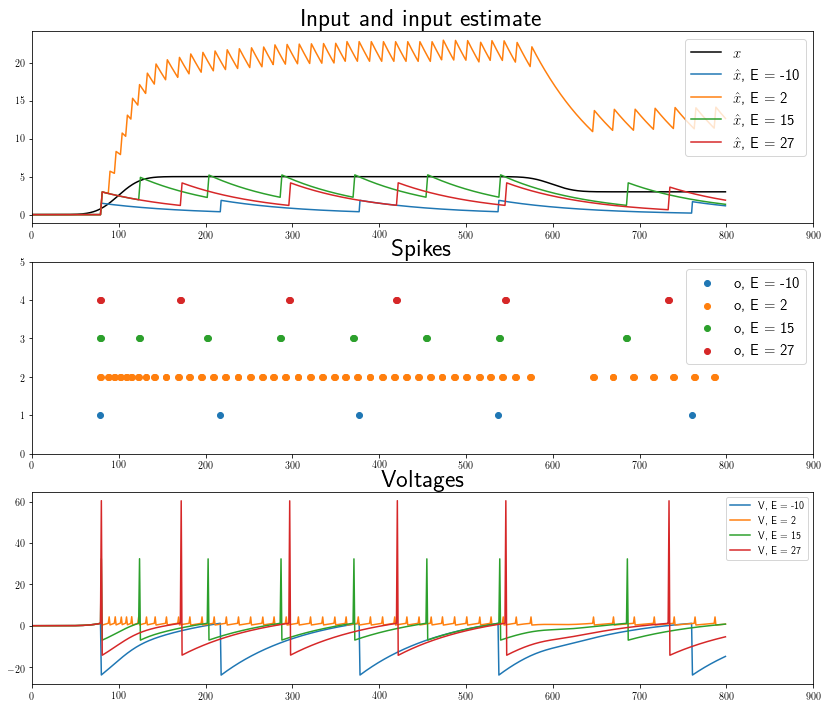

In [10]:
# range 
lines = 4
E = np.linspace(-10, 40, lines + 1)

# time signal
x,c = TVS_single()

# initiate plots
plots = 3
pl.subplots(plots, 1, figsize=(14, 12))

# plot input and input estimate
pl.subplot(plots, 1, 1)
pl.plot(x, 'k', label=r'$x$')
pl.title('Input and input estimate', fontsize=25)
pl.xlim(0, iterations + 100)
for i in range(lines):
    t, x_est, o, voltage, T, spike, t_spike = initialize_params_single(dt, iterations, gamma)
    run_single(E[i])
    pl.plot(x_est, label=r'$\hat{x}$, E = %i' %E[i])
    pl.legend(fontsize=15)
    
# plot spike times
pl.subplot(plots, 1, 2)
pl.title('Spikes', fontsize=25)
pl.ylim(0, i + 2)
pl.xlim(0, iterations + 100)
for i in range(lines):
    t, x_est, o, voltage, T, spike, t_spike = initialize_params_single(dt, iterations, gamma)
    run_single(E[i])
    spike_train = multiplylist(spike, i + 1)
    pl.scatter(t_spike, spike_train, label='o, E = %i' %E[i])
    pl.legend(fontsize=15)
    
# plot voltages
pl.subplot(plots, 1, 3)
pl.title('Voltages', fontsize=25)
pl.xlim(0, iterations + 100)
for i in range(lines):
    t, x_est, o, voltage, T, spike, t_spike = initialize_params_single(dt, iterations, gamma)
    run_single(E[i])
    pl.plot(voltage, label="V, E = %i" %E[i])
    pl.legend()

## $\textit{N}$-neurons (homogeneous network)

Initialize parameters

In [5]:
def initialize_params_homogeneous(N, dt, iterations, gamma, mu):

    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike trains
    o = np.zeros((N, iterations))

    # voltages
    voltage = np.zeros((N, iterations))

    # ''output kernel''
    D = np.ones((1, N)) * gamma

    # threshold
    T = []
    for i in range(N):
        T.append((D[0][i] ** 2)/2 + mu/2)

    return (t, x_est, o, voltage, D, T) 

Create time varying signal

In [59]:
def TVS_homogeneous(c_upp=3):

    # create time-varying signal
    x = c_upp
    x_t = np.ones(iterations) * x

    step = 150
    x_t[0:step] = 0
    x_t[iterations - 4 * step:iterations] = 1

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

Run simulation

In [7]:
def run_homogeneous(E, noise_signal=0):
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[t - 1] + np.dot(D, o[:, t - 1])
        x_est[t] = x_est[t - 1] + dt * dxestdt
        
        # compute update value
        update_weighted = np.dot(D.T * D + np.identity(N) * mu , o[:, t - 1])
        driving_force = voltage[:, t - 1] - E
        update = np.zeros(N)
        for i in range(N):
            update[i] = update_weighted[i] * driving_force[i]
        
        # update voltage
        dVdt = -voltage[:, t - 1] + D[0] * c[t - 1] - update
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        above_threshold = []

        for i in range(N): 
            if voltage[i, t] > T[i]:
                above_threshold.append(i)

        # reset neuron when threshold is exceeded
        if len(above_threshold) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.choice(above_threshold)

            # update spikes
            o[spike_neuron, t] = 1/dt

Plot results

In [38]:
def plot_homogeneous(E, color, plot_voltage=1):
    plots = N + 2
    pl.subplots(plots, 1, figsize=(14, 12)) 
    pl.subplots_adjust(hspace=0.7)

    # enable LaTeX
    pl.rc('text', usetex=True)

    pl.subplot(plots, 1, 1)
    pl.title('Input and input estimate', fontsize=25)
    pl.plot(x, label=r'$x$', color='black')
    pl.plot(x_est, label=r'$\hat{x}$', color='gray')
#     pl.yticks([])
#     pl.xticks([])
    pl.xlim(0, iterations)
    pl.legend()
    
    pl.subplot(plots, 1, 2)
    pl.title('Spikes', fontsize=25)
    for i in range(1, N + 1):
        
        values = zero_to_nan(o[i - 1, :] * i)
                
        pl.scatter(np.arange(0, iterations), values, color=color[i - 1][:]/255, label='Neuron %i' %i)
        pl.yticks([])
        pl.xticks([])
        pl.title('Spike train', fontsize=25)
        pl.ylim(0, 100 * N + 100)
        pl.xlim(0, iterations)
        
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    counter = 3

    for i in range(1, N + 1):
        neuron = i + 1

        pl.subplot(plots, 1, counter)
        pl.title('Voltage N%i with E= %.01f' %(i, E[i - 1]), fontsize=25)
        pl.plot(voltage[i - 1], color=color[i - 1][:]/255)
        pl.xlim(0, iterations)
        pl.ylabel('Voltage')
        pl.ylim((min(E) * gamma**2) - 10, 10)

        counter = counter + 1

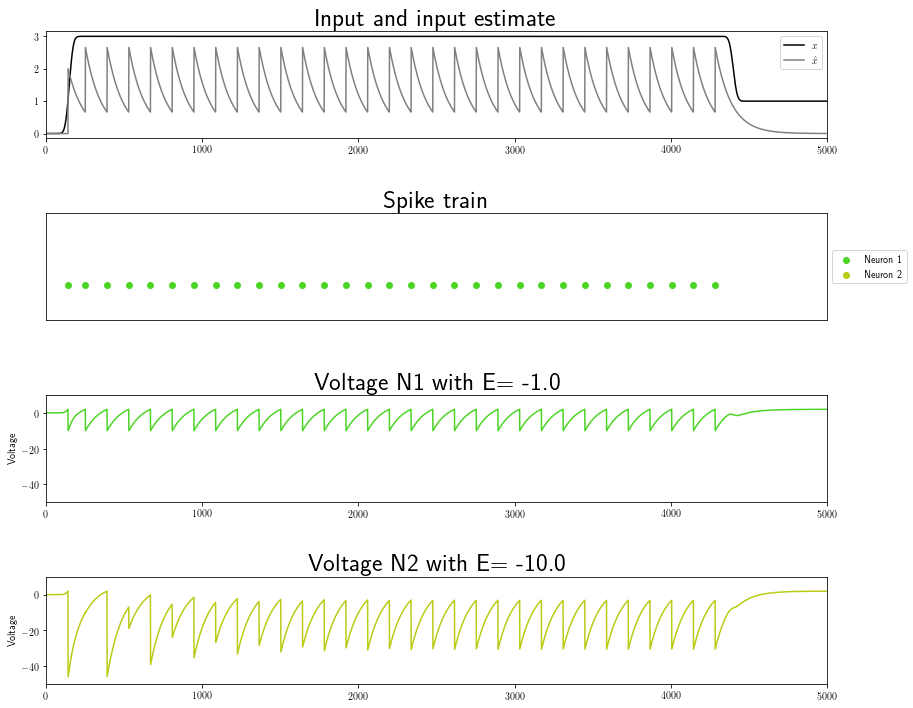

In [60]:
# Run simulation and plot results for given parameters
N = 2                       # number of neurons  
c_upp = 3                   # value input signal
dt = 0.01                   # step size
iterations = 5000           # number of time steps
gamma = 2                   # weights
mu = 0                      # regularization
color = colors(N)           # return set of colors
# dVdt_all = np.zeros((N, iterations))

# initliaze reversal potentials
E = np.ones(N) * -1
E[1] = -10

# run simulation
t, x_est, o, voltage, D, T = initialize_params_homogeneous(N, dt, iterations, gamma, mu)
x,c = TVS_homogeneous(c_upp)
run_homogeneous(E, noise_signal=0)
plot_homogeneous(E, color, plot_voltage=1)

Plot voltage derivatives over time

In [78]:
# Y1 = []
# Y2 = []
# c = 5               # input signal

# start = -100
# end = 10
# steps = 10

# y1 = np.linspace(start, end, steps)
# y2 = np.linspace(start, end, steps)

# U, V = np.meshgrid(y1,y2)
 
# for v in range(len(y1)):
#     temp = -y1[v] + gamma * c - (gamma ** 2) * (y1[v] - E[0])
    
#     Y1.append(temp)
    
     
# for v in range(len(y1)):
#     temp = -y1[v] + gamma * c - (gamma ** 2) * (y1[v] - E[1])
    
#     Y2.append(temp)

# pl.quiver(U, V, Y1, Y2, alpha=0.2)
# pl.xlabel('N1')
# pl.ylabel('N2')

## Voltage dynamics
    
$ \frac{dV}{dt} = -V + \Gamma c - \Gamma^{2} (V - E)$ 

Solve for $\frac{dV}{dt} = 0$

$ \frac{dV}{dt} = -V + \Gamma c - \Gamma^{2} V + \Gamma^{2} E = 0$

$V + \Gamma^{2} V  = \Gamma c + \Gamma^{2} E$

$(1 + \Gamma^{2}) V = \Gamma c + \Gamma^{2} E$

$V = \frac{\Gamma c + \Gamma^{2}E}{1 + \Gamma^{2}}$

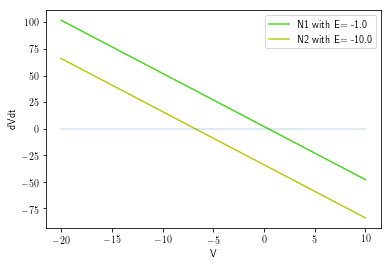

In [76]:
steps = 10
start = gamma * -10
end = 10
voltage = np.linspace(start, end, steps) 

for i in range(1, N + 1):
    dVdt = np.zeros(steps)
    
    for v in range(steps):
        dVdt[v] = -voltage[v] + gamma * c_upp - (gamma ** 2) * (voltage[v] - E[i - 1])
        
    pl.plot(voltage, dVdt, color=color[i - 1][:]/255, label='N%i with E= %.01f' %(i, E[i - 1]))
    
pl.xlabel('V')
pl.ylabel('dVdt')
pl.plot(np.linspace(start, end, steps), np.zeros(steps), alpha=0.2)
pl.legend()